First let's load the Jar. This requires `mill q.assembly` to be run beforehand.

In [1]:
interp.load.cp(os.pwd/".."/"out"/"q"/"assembly.dest"/"out.jar")

We will load some boilerplate code for graphing as well.

In [2]:
import $file.makeplot

import $file.$

Now, all the imports...

In [3]:
import riscq._
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import scala.collection.mutable.ArrayBuffer
import spinal.lib._
import riscq.soc.MemoryMapSoc
import riscq.tester.RvAssembler
import riscq.tester.mmsoc.MMSocDriver
import spinal.lib.misc.Elf
import java.io.File
import riscq.soc.MemoryMapSoc
import riscq.soc.MemoryMapPlugins
import net.fornwall.jelf.ElfSectionHeader
import riscq.tester.mmsoc._

import riscq._
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import scala.collection.mutable.ArrayBuffer
import spinal.lib._
import riscq.soc.MemoryMapSoc
import riscq.tester.RvAssembler
import riscq.tester.mmsoc.MMSocDriver
import spinal.lib.misc.Elf
import java.io.File
import riscq.soc.MemoryMapSoc
import riscq.soc.MemoryMapPlugins
import net.fornwall.jelf.ElfSectionHeader
import riscq.tester.mmsoc._

Copying over the body of `TestMMSocPulse` from `MMSocTestBench.scala` and pushing the DAC outputs into an `ArrayBuffer`

In [4]:
val dac_output = ArrayBuffer[Double]()
val carrier_output = ArrayBuffer[Double]()
val simConfig = SimConfig.addSimulatorFlag("-Wno-MULTIDRIVEN")
simConfig.compile {
  val dut = MemoryMapSoc(
    qubitNum = 4,
    withVivado = false,
    withCocotb = false,
    withWhitebox = true,
    withTest = true) 
  dut.pgs.map { _.io.simPublic() }
  dut.cgs.map { _.io.simPublic() }
  dut }.doSim { dut =>
  val driver = new Driver(dut)
  import driver._
  init()
  val pgId = 2

  val batchSize = 16
  val dataWidth = 16
  for (i <- 0 until 100) {
    val dt = if (i == 0) BigInt(10) else BigInt(1000)
    val batch = List.fill(batchSize)(dt)
    val batchData = riscq.pulse.PGTestPulse.concat(batch, dataWidth)
    val dataStr = batch.map { x => ByteHelper.intToBinStr(x, dataWidth) }.reduce { _ ++ _ }
    tlDriver.putFullData(0, dut.pmAxiOffset + (1 << 21) + i * batchSize * dataWidth / 8, ByteHelper.fromBinStr(dataStr).reverse)
    // axi4Driver.write(dut.pmAxiOffset + i * batchSize * dataWidth / 8, ByteHelper.fromBinStr(dataStr).reverse.toList)
  }
  cd100m.waitRisingEdge()

  val elfFile = new File("../compiler-scripts/pg_test.elf")
  val elf = new Elf(elfFile, addressWidth = 32)
  elf.load(dut.mem.mem, -0x80000000)

  val startTime = 50

  dut.riscq_rst #= true
      tick(10)
      dut.riscq_rst #= false
      tick(30)
      for(t <- 100 until 500 by 100) {
      driver.waitUntil(t - 1)
      for(i <- 0 until 10) {
      logTime()
      logDac(pgId)
      logCarrier(pgId)
      val dac = dut.pgs(2).io.data
      val pulse = dac.payload.map { _.r.toDouble * (1 << 14) }.toList
      dac_output ++= pulse
      val carrier = dut.cgs(2).io.carrier
      val data = carrier.payload.map { _.r.toDouble * (1 << 14) }.toList
      carrier_output ++= data
      tick()
    }
      }}
        
        
        

[Runtime] SpinalHDL dev    git head : bbe3c9911a233a5aa9672c70d237336385ab7dcc
[Runtime] JVM max memory : 3910.0MiB
[Runtime] Current date : 2025.04.05 14:12:59
[Progress] at 0.000 : Elaborate components
debug jumps: ArrayBuffer(toplevel/riscqArea_riscq/null)
########################1
debug hazard ctrlrange: Range 0 to 0
debug hazard ds: 0
!!!!!!!!!!!!!###########Range 0 until 2
!!!!!!!!!!!!!###########Range 0 until 2
[Progress] at 4.229 : Checks and transforms
[Progress] at 5.830 : Generate Verilog to ./simWorkspace/tmp/job_1
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/cd100mLogic_pulseMemWa_logic_bridge/upsize_d_ctx/contexts : Mem[16*3 bits].readAsync can only be write first into Verilog
[Warning] toplevel/riscq

carrier ev: v: false, freq: 0.04998779296875, phase: 0.0
List(3244.0, 5716.0, 8047.0, 10179.0, 12062.0, 13646.0, 14897.0, 15780.0, 16274.0, 16368.0, 16059.0, 15355.0, 14273.0, 12839.0, 11090.0, 9067.0)
time: 208
pulse ev: v: false, amp: 28672, start: 200
pulse: List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
carrier ev: v: false, freq: 0.04998779296875, phase: 0.0
List(6821.0, 4408.0, 1886.0, -682.0, -3234.0, -5706.0, -8037.0, -10172.0, -12055.0, -13642.0, -14892.0, -15777.0, -16273.0, -16369.0, -16063.0, -15359.0)
time: 299
pulse ev: v: false, amp: 28672, start: 300
pulse: List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
carrier ev: v: false, freq: 0.074981689453125, phase: 0.0
List(-10375.0, -13047.0, -14999.0, -16124.0, -16357.0, -15686.0, -14150.0, -11831.0, -8860.0, -5399.0, -1639.0, 2211.0, 5939.0, 9338.0, 12222.0, 14431.0)
time: 300
pulse ev: v: false, amp: 28672, start: 300
pulse: List(0.0, 2.0, 4.0, 5.0, 

dac_output: ArrayBuffer[Double] = ArrayBuffer(
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -7.0,
  -7.0,
  -6.0,
  -6.0,
  -5.0,
  -5.0,
  -4.0,
  -4.0,
  -3.0,
  -3.0,
  -2.0,
  -1.0,
  -1.0,
  0.0,
  1.0,
  1.0,
  252.0,
  317.0,
  380.0,
  441.0,
  499.0,
  553.0,
...
carrier_output: ArrayBuffer[Double] = ArrayBuffer(
  4682.0,
  5899.0,
  7080.0,
  8217.0,
  9304.0,
  10333.0,
  11298.0,
  12194.0,
  13015.0,
  13755.0,
  14410.0,
  14978.0,
  15452.0,
  15832.0,
  16114.0,
  16297.0,
  16377.0,
  16358.0,
  16238.0,
  16018.0,
  15700.0,
  15285.0,
  14775.0,
  14174.0,
  13487.0,
  12716.0,
  11865.0,
  10943.0,
  9954.0,
  8902.0,
  7796.0,
  6642.0,
  5447.0,
  4219.0,
  2964.0,
  1692.0,
  407.0,
  -878.0,
...
simConfig: SpinalSimConfig = SpinalSimConfig(
  "./simWorkspace",
  null,
  0,
  SpinalConfig(
    null,
    Set(),
    Set(),
    false,
    ClockDomainConfig(RISING, ASYNC, HIGH, HIGH, HIGH),
    fal

Plotting...

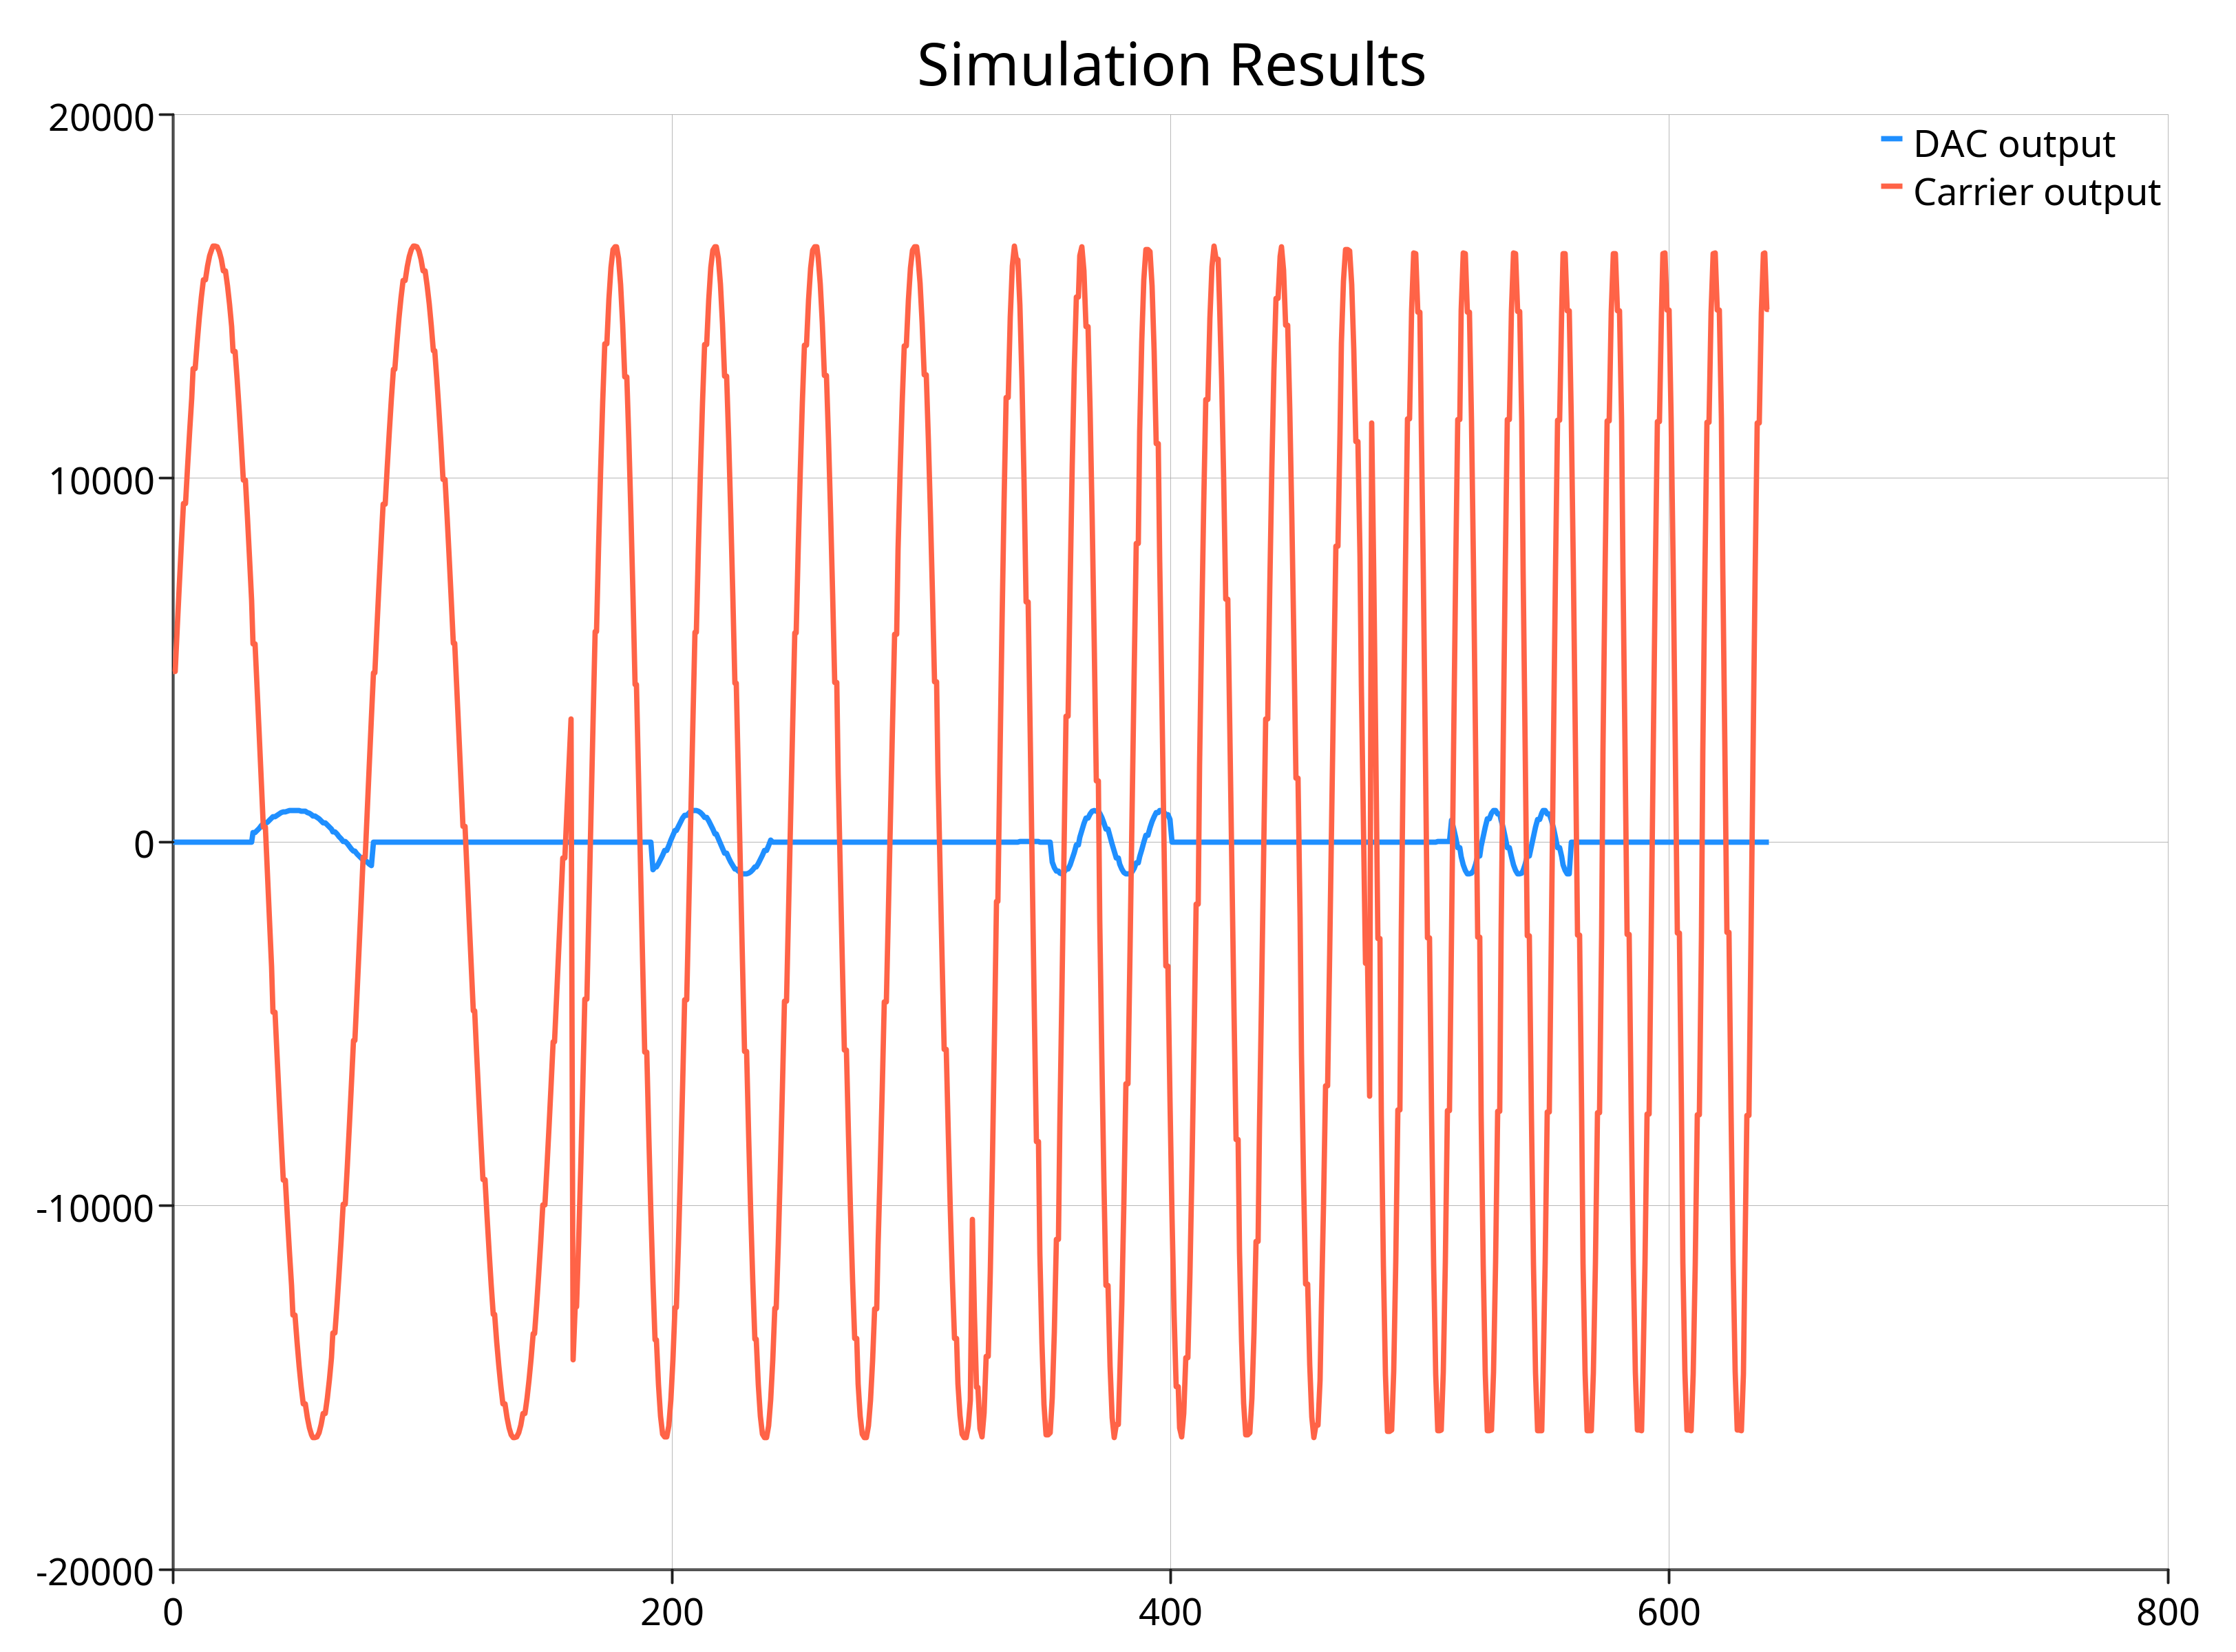

pngBytes: Array[Byte] = Array(
  -119,
  80,
  78,
  71,
  13,
  10,
  26,
  10,
  0,
  0,
  0,
  13,
  73,
  72,
  68,
  82,
  0,
  0,
  12,
  -80,
  0,
  0,
  9,
  96,
  8,
  6,
  0,
  0,
  0,
  34,
  11,
  47,
  101,
  0,
  0,
  -128,
  0,
  73,
...

In [5]:
val pngBytes = makeplot.make_plot(List(makeplot.LabeledData("DAC output", dac_output), makeplot.LabeledData("Carrier output", carrier_output)))
Image(pngBytes)